
# TGTG — Waste Hyperparameter Grid (Full Factorial + Interaction Modeling)

This notebook generates a **granular full-factorial dataset** to study how **waste** changes with hyperparameters and **how those hyperparameters interact**.

It uses the fast compiled simulator in **`tgtg_fast.py`** and, for each hyperparameter combination, trains:

- **Baseline (no TGTG)**: force $b=0$
- **TGTG-available**: optimize both $q$ and $b$

Then it evaluates both policies **out-of-sample** and stores:

- `waste_base`, `waste_tgtg`, `delta_waste`
- `profit_base`, `profit_tgtg`, `delta_profit`
- `prod_base`, `prod_tgtg`, `delta_prod`
- `b_star` (optimal reserved share)

Finally, it:
- visualizes waste as **surfaces/heatmaps** over all combinations (conditioning/faceting as needed),
- fits **interaction models** (linear interactions + random forest) to quantify the joint effects.

---

## Important implementation note
This simulator treats $\tau$ as a **per-unit** TGTG price (salvage price).  
If you want “bags of size $k$” sold at price $\tau$ per bag, the simulator needs a small adjustment.


In [2]:

# --- Imports & wiring (tgtg_fast.py must be importable) ---
import sys
import os
import time
from pathlib import Path

sys.path.append("/mnt/data")  # where tgtg_fast.py is placed in this environment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

from tgtg_fast import (
    EnvironmentConfig, BakerAgent,
    generate_preferences,
    make_common_random_draws,
    alpha_path_constant, alpha_path_beta_shocks, alpha_path_logit_ar1,
    simulate_epoch_fast
)

np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 200)

OUT_DIR = Path("./tgtg_waste_grid_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_DIR


PosixPath('tgtg_waste_grid_outputs')


## 1) Core optimizer & evaluation helpers

This is the same evolutionary logic as the earlier notebook:
- common random numbers per generation
- Numba-compiled epoch simulator
- parallel evaluation

The objective is not “perfect optimization”, but a stable approximate best-response for comparative statics.


In [3]:

def clip_agent(agent: BakerAgent, q_max: int) -> BakerAgent:
    q = np.clip(np.floor(agent.q), 0, q_max).astype(np.int64)
    b = float(np.clip(agent.b, 0.0, 1.0))
    return BakerAgent(q=q, b=b, gamma=float(agent.gamma))


def init_population(P: int, L: int, gamma: float, q_max: int, rng: np.random.Generator) -> list[BakerAgent]:
    pop = []
    for _ in range(P):
        q = rng.integers(low=0, high=q_max + 1, size=L, dtype=np.int64)
        b = float(rng.random())
        pop.append(BakerAgent(q=q, b=b, gamma=float(gamma)))
    return pop


def mutate(agent: BakerAgent, q_sigma: float, b_sigma: float, q_max: int, rng: np.random.Generator) -> BakerAgent:
    q = agent.q.astype(np.float64) + rng.normal(0.0, q_sigma, size=agent.q.shape[0])
    b = float(agent.b + rng.normal(0.0, b_sigma))
    return clip_agent(BakerAgent(q=q, b=b, gamma=agent.gamma), q_max=q_max)


def evaluate_population_parallel_threads(
    population: list[BakerAgent],
    prefs: np.ndarray,
    env: EnvironmentConfig,
    alpha_path: np.ndarray,
    perm: np.ndarray,
    visit_u: np.ndarray,
    walk_u: np.ndarray,
    max_workers: int | None = None,
) -> tuple[np.ndarray, list[dict]]:
    if max_workers is None:
        max_workers = max(1, os.cpu_count() or 1)

    metrics_list = [None] * len(population)

    def _eval_one(idx: int):
        m = simulate_epoch_fast(population[idx], prefs, env, alpha_path, perm, visit_u, walk_u)
        return idx, m

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(_eval_one, i) for i in range(len(population))]
        for f in as_completed(futures):
            idx, m = f.result()
            metrics_list[idx] = m

    fitness = np.array([m["fitness"] for m in metrics_list], dtype=np.float64)
    return fitness, metrics_list


def make_alpha_path(D: int, demand_spec: dict, rng: np.random.Generator) -> np.ndarray:
    k = demand_spec["kind"]
    if k == "constant":
        return alpha_path_constant(D, demand_spec["alpha"])
    if k == "beta":
        return alpha_path_beta_shocks(D, demand_spec["alpha_mean"], demand_spec["concentration"], rng)
    if k == "ar1":
        return alpha_path_logit_ar1(D, demand_spec["alpha0"], demand_spec["phi"], demand_spec["sigma"], rng)
    raise ValueError(f"Unknown demand spec kind: {k}")


def evolutionary_optimize(
    env: EnvironmentConfig,
    demand_spec: dict,
    *,
    gamma: float,
    allow_tgtg: bool,
    preference_mode: str,
    seed: int,
    D: int,
    P: int,
    G: int,
    elite_frac: float,
    q_max: int,
    q_sigma: float,
    b_sigma: float,
    n_workers_eval: int | None = None,
) -> dict:
    rng = np.random.default_rng(seed)
    prefs = generate_preferences(env.N, env.L, mode=preference_mode, rng=rng)

    pop = init_population(P, env.L, gamma=gamma, q_max=q_max, rng=rng)
    if not allow_tgtg:
        for a in pop:
            a.b = 0.0

    elite_n = max(2, int(P * elite_frac))
    history = []

    # Warm-up compile once
    perm0, visit0, walk0 = make_common_random_draws(D, env.N, env.L, seed=seed + 10_000)
    alpha0 = make_alpha_path(D, demand_spec, np.random.default_rng(seed + 20_000))
    _ = simulate_epoch_fast(pop[0], prefs, env, alpha0, perm0, visit0, walk0)

    best_fit = -1e18
    best_agent = None
    best_metrics = None

    for g in range(G):
        perm, visit_u, walk_u = make_common_random_draws(D, env.N, env.L, seed=seed + 1_000_000 + g)
        alpha_path = make_alpha_path(D, demand_spec, np.random.default_rng(seed + 2_000_000 + g))

        fitness, metrics_list = evaluate_population_parallel_threads(
            pop, prefs, env, alpha_path, perm, visit_u, walk_u, max_workers=n_workers_eval
        )

        order = np.argsort(fitness)[::-1]
        elites = [pop[i] for i in order[:elite_n]]
        elite_metrics = [metrics_list[i] for i in order[:elite_n]]

        if float(fitness[order[0]]) > best_fit:
            best_fit = float(fitness[order[0]])
            best_agent = elites[0]
            best_metrics = elite_metrics[0]

        history.append({
            "gen": g,
            "best_fitness": float(fitness[order[0]]),
            "mean_fitness": float(np.mean(fitness)),
            "best_production": float(metrics_list[order[0]]["production"]),
            "best_waste": float(metrics_list[order[0]]["waste"]),
            "best_b": float(pop[order[0]].b),
        })

        # reproduce
        new_pop = elites.copy()
        while len(new_pop) < P:
            parent = elites[rng.integers(0, elite_n)]
            child = mutate(parent, q_sigma=q_sigma, b_sigma=b_sigma, q_max=q_max, rng=rng)
            if not allow_tgtg:
                child.b = 0.0
            new_pop.append(child)
        pop = new_pop

    return {
        "best_agent": best_agent,
        "best_fit": best_fit,
        "best_metrics_train": best_metrics,
        "prefs": prefs,
        "history": pd.DataFrame(history),
        "env": env,
        "demand_spec": demand_spec,
        "seed": seed,
        "D": D,
    }


def out_of_sample_eval(
    agent: BakerAgent,
    prefs: np.ndarray,
    env: EnvironmentConfig,
    demand_spec: dict,
    *,
    seed: int,
    D: int,
    reps: int
) -> pd.DataFrame:
    rows = []
    for j in range(reps):
        perm, visit_u, walk_u = make_common_random_draws(D, env.N, env.L, seed=seed + 100_000 + j)
        alpha_path = make_alpha_path(D, demand_spec, np.random.default_rng(seed + 200_000 + j))
        m = simulate_epoch_fast(agent, prefs, env, alpha_path, perm, visit_u, walk_u)
        m = dict(m)
        m["rep"] = j
        rows.append(m)
    return pd.DataFrame(rows)



## 2) Define the granular full-factorial grid

You can make this as granular as you want by adding more points to each list.

Core dimensions:
- $L$: number of goods
- margin $\rho/\chi$
- discount $\tau/\rho$
- volatility: Beta concentration (lower = more volatile)

We keep $\mathbb{E}[\alpha_t]$ fixed by default (you can sweep it too).


In [4]:

BASE = dict(
    N=600, # number of consumers
    r=0.35, 
    chi=1.0,
    alpha_mean=0.35,
)

GRID = dict(
    L=[3, 4, 5, 6, 8, 10],
    margin_rho_over_chi=[1.6, 2.0, 2.5, 3.0, 3.6],
    discount_tau_over_rho=[0.15, 0.25, 0.35, 0.5, 0.7],
    beta_concentration=[3.0, 5.0, 10.0, 20.0, 50.0, 100.0],
)

BUDGET = dict(
    gamma=0.8,
    D=50, # days per epoch
    P=500, # population size
    G=26,
    elite_frac=0.20,
    q_max=140,
    q_sigma=12.0,
    b_sigma=0.08,
    oos_reps=20,
    preference_mode="correlated",
)

# Parallelism
OUTER_WORKERS = max(1, (os.cpu_count() or 1) // 2)  # processes
INNER_EVAL_WORKERS = 1                               # threads within each process

RESULTS_CSV = OUT_DIR / "waste_grid_results.csv"
RESULTS_PARQUET = OUT_DIR / "waste_grid_results.parquet"

print("Outer workers:", OUTER_WORKERS)
print("Inner eval workers:", INNER_EVAL_WORKERS)


Outer workers: 4
Inner eval workers: 1


In [5]:

def iter_full_factorial(grid: dict) -> list[dict]:
    keys = list(grid.keys())
    combos = []
    def rec(i, cur):
        if i == len(keys):
            combos.append(cur.copy())
            return
        k = keys[i]
        for v in grid[k]:
            cur[k] = v
            rec(i+1, cur)
    rec(0, {})
    return combos

combos = iter_full_factorial(GRID)
print("Total combinations:", len(combos))
combos[:3]


Total combinations: 900


[{'L': 3,
  'margin_rho_over_chi': 1.6,
  'discount_tau_over_rho': 0.15,
  'beta_concentration': 3.0},
 {'L': 3,
  'margin_rho_over_chi': 1.6,
  'discount_tau_over_rho': 0.15,
  'beta_concentration': 5.0},
 {'L': 3,
  'margin_rho_over_chi': 1.6,
  'discount_tau_over_rho': 0.15,
  'beta_concentration': 10.0}]


## 3) Scenario runner (one combo → one row of results)

For each combo:
1) build environment (prices implied by margin + discount)
2) demand spec = Beta shocks with given concentration
3) train two policies: baseline vs TGTG
4) out-of-sample evaluation
5) compute waste, deltas, and store

Checkpointing:
- results are written to CSV repeatedly
- rerunning resumes from where you left off


In [6]:

def make_env_and_demand(combo: dict):
    L = int(combo["L"])
    margin = float(combo["margin_rho_over_chi"])
    disc = float(combo["discount_tau_over_rho"])
    conc = float(combo["beta_concentration"])

    rho = margin * BASE["chi"]
    tau = disc * rho

    env = EnvironmentConfig(
        N=int(BASE["N"]),
        L=L,
        r=float(BASE["r"]),
        chi=float(BASE["chi"]),
        rho=float(rho),
        tau=float(tau),
    )
    demand_spec = {
        "kind": "beta",
        "alpha_mean": float(BASE["alpha_mean"]),
        "concentration": float(conc),
        "label": f"beta(conc={conc})"
    }
    return env, demand_spec


def scenario_key(combo: dict) -> str:
    return "|".join([
        f"L={combo['L']}",
        f"m={combo['margin_rho_over_chi']}",
        f"d={combo['discount_tau_over_rho']}",
        f"c={combo['beta_concentration']}",
    ])


def run_one_combo(combo: dict, seed: int) -> dict:
    env, demand_spec = make_env_and_demand(combo)

    # Train (same seed → comparable prefs)
    out_t = evolutionary_optimize(
        env, demand_spec,
        gamma=BUDGET["gamma"],
        allow_tgtg=True,
        preference_mode=BUDGET["preference_mode"],
        seed=seed,
        D=BUDGET["D"],
        P=BUDGET["P"],
        G=BUDGET["G"],
        elite_frac=BUDGET["elite_frac"],
        q_max=BUDGET["q_max"],
        q_sigma=BUDGET["q_sigma"],
        b_sigma=BUDGET["b_sigma"],
        n_workers_eval=INNER_EVAL_WORKERS,
    )
    out_b = evolutionary_optimize(
        env, demand_spec,
        gamma=BUDGET["gamma"],
        allow_tgtg=False,
        preference_mode=BUDGET["preference_mode"],
        seed=seed,
        D=BUDGET["D"],
        P=BUDGET["P"],
        G=BUDGET["G"],
        elite_frac=BUDGET["elite_frac"],
        q_max=BUDGET["q_max"],
        q_sigma=BUDGET["q_sigma"],
        b_sigma=BUDGET["b_sigma"],
        n_workers_eval=INNER_EVAL_WORKERS,
    )

    oos_seed = seed + 777
    oos_t = out_of_sample_eval(out_t["best_agent"], out_t["prefs"], env, demand_spec, seed=oos_seed, D=BUDGET["D"], reps=BUDGET["oos_reps"])
    oos_b = out_of_sample_eval(out_b["best_agent"], out_b["prefs"], env, demand_spec, seed=oos_seed, D=BUDGET["D"], reps=BUDGET["oos_reps"])

    row = dict(combo)
    row["key"] = scenario_key(combo)
    row["seed"] = seed

    row["waste_base"] = float(oos_b["waste"].mean())
    row["waste_tgtg"] = float(oos_t["waste"].mean())
    row["delta_waste"] = row["waste_tgtg"] - row["waste_base"]

    row["profit_base"] = float(oos_b["mean_profit"].mean())
    row["profit_tgtg"] = float(oos_t["mean_profit"].mean())
    row["delta_profit"] = row["profit_tgtg"] - row["profit_base"]

    row["prod_base"] = float(oos_b["production"].mean())
    row["prod_tgtg"] = float(oos_t["production"].mean())
    row["delta_prod"] = row["prod_tgtg"] - row["prod_base"]

    row["b_star"] = float(out_t["best_agent"].b)

    # per-day
    D = float(BUDGET["D"])
    row["waste_base_per_day"] = row["waste_base"] / D
    row["waste_tgtg_per_day"] = row["waste_tgtg"] / D
    row["delta_waste_per_day"] = row["delta_waste"] / D

    row["prod_base_per_day"] = row["prod_base"] / D
    row["prod_tgtg_per_day"] = row["prod_tgtg"] / D
    row["delta_prod_per_day"] = row["delta_prod"] / D

    return row


In [7]:

def load_existing_results(path_csv: Path) -> pd.DataFrame:
    if path_csv.exists():
        return pd.read_csv(path_csv)
    return pd.DataFrame()

def save_results(df: pd.DataFrame):
    df.to_csv(RESULTS_CSV, index=False)
    try:
        df.to_parquet(RESULTS_PARQUET, index=False)
    except Exception:
        pass

def run_full_grid(
    combos: list[dict],
    *,
    seed_base: int = 2026,
    outer_workers: int = OUTER_WORKERS,
    resume: bool = True,
    flush_every: int = 5,
) -> pd.DataFrame:
    existing = load_existing_results(RESULTS_CSV) if resume else pd.DataFrame()
    done = set(existing["key"].astype(str).tolist()) if (resume and len(existing) > 0) else set()

    pending = [c for c in combos if scenario_key(c) not in done]
    print(f"Total combos: {len(combos)} | already done: {len(done)} | pending: {len(pending)}")
    if len(pending) == 0:
        return existing

    rows = []
    t0 = time.time()

    with ProcessPoolExecutor(max_workers=outer_workers) as ex:
        futures = {}
        for idx, combo in enumerate(pending):
            seed = seed_base + idx * 13
            futures[ex.submit(run_one_combo, combo, seed)] = combo

        for j, f in enumerate(as_completed(futures), 1):
            row = f.result()
            rows.append(row)

            if j % flush_every == 0:
                df_new = pd.DataFrame(rows)
                df_all = pd.concat([existing, df_new], ignore_index=True).drop_duplicates(subset=["key"], keep="first")
                save_results(df_all)
                elapsed = time.time() - t0
                print(f"{j}/{len(pending)} completed | elapsed {elapsed:.1f}s | checkpoint saved")

    df_new = pd.DataFrame(rows)
    df_all = pd.concat([existing, df_new], ignore_index=True).drop_duplicates(subset=["key"], keep="first")
    save_results(df_all)
    return df_all



## 4) Run the grid (checkpointed + resumable)

This cell runs the full factorial grid and writes results to:
- `OUT_DIR / waste_grid_results.csv`

You can interrupt at any time and re-run: it resumes automatically.


In [ ]:

df = run_full_grid(combos, seed_base=2026, outer_workers=OUTER_WORKERS, resume=True, flush_every=3)
df.shape, df.head()


Total combos: 900 | already done: 588 | pending: 312


3/312 completed | elapsed 20.0s | checkpoint saved
6/312 completed | elapsed 38.6s | checkpoint saved
9/312 completed | elapsed 56.9s | checkpoint saved
12/312 completed | elapsed 60.3s | checkpoint saved
15/312 completed | elapsed 81.7s | checkpoint saved
18/312 completed | elapsed 102.1s | checkpoint saved
21/312 completed | elapsed 123.2s | checkpoint saved
24/312 completed | elapsed 126.5s | checkpoint saved
27/312 completed | elapsed 147.6s | checkpoint saved
30/312 completed | elapsed 169.8s | checkpoint saved
33/312 completed | elapsed 191.6s | checkpoint saved
36/312 completed | elapsed 194.8s | checkpoint saved
39/312 completed | elapsed 215.9s | checkpoint saved
42/312 completed | elapsed 237.5s | checkpoint saved
45/312 completed | elapsed 258.2s | checkpoint saved
48/312 completed | elapsed 263.6s | checkpoint saved
51/312 completed | elapsed 286.8s | checkpoint saved
54/312 completed | elapsed 308.2s | checkpoint saved
57/312 completed | elapsed 336.2s | checkpoint saved
6


## 5) Granular interaction visualizations

We visualize “all combinations” by taking 2D slices and faceting the other dimensions.

Main plot: heatmap over (margin, discount) conditioned on $L$ and concentration.

You can change `value_col` to:
- `waste_tgtg_per_day`
- `waste_base_per_day`
- `delta_waste_per_day`


In [ ]:
df = pd.read_csv(RESULTS_CSV)

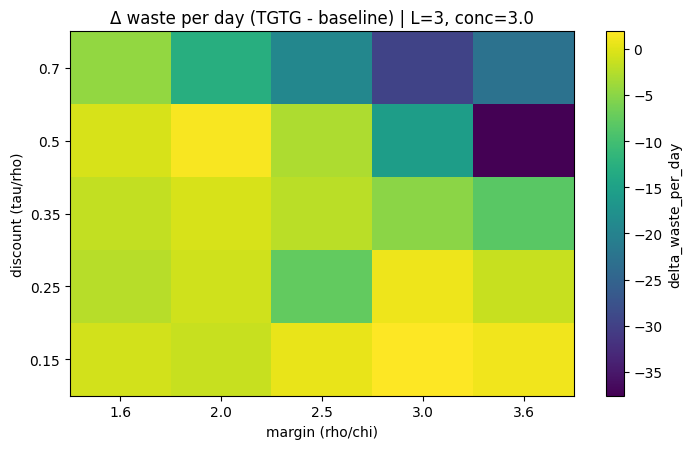

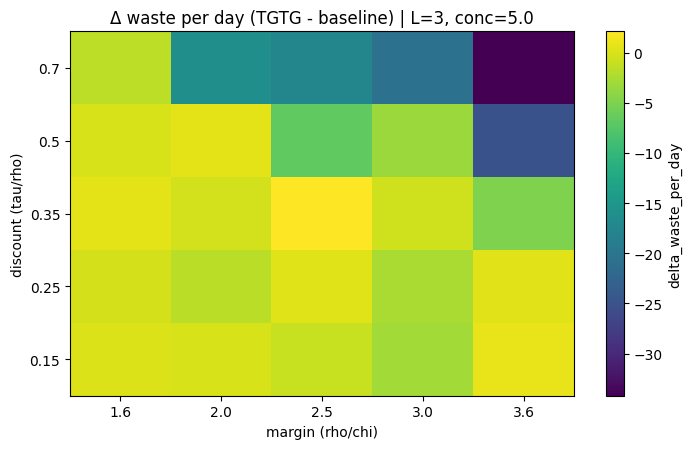

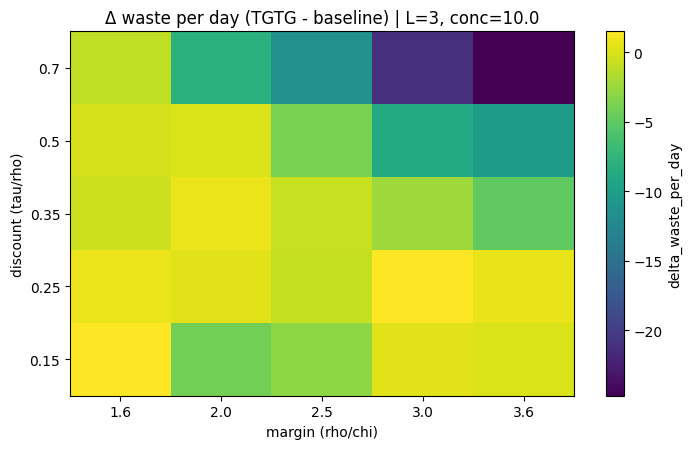

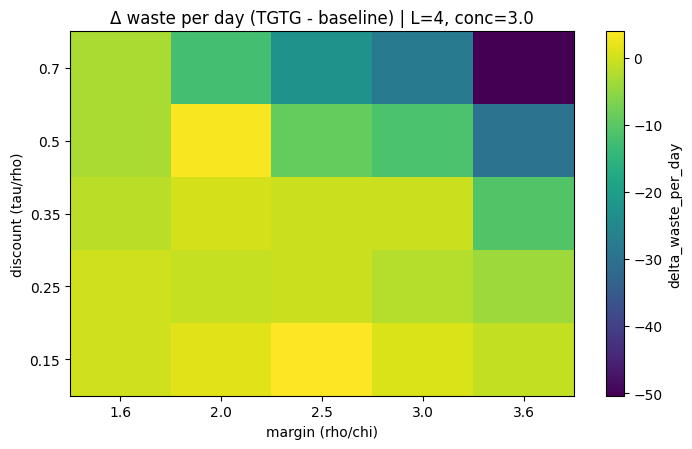

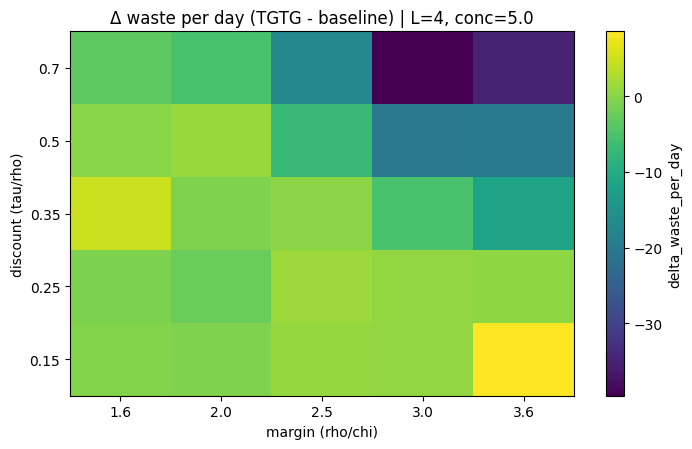

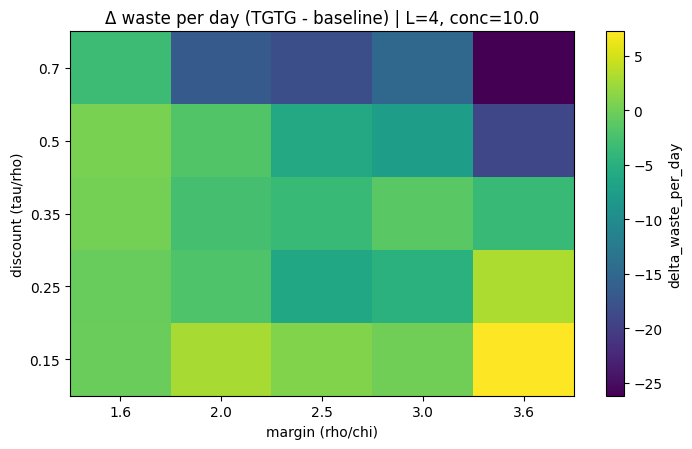

In [ ]:

def heatmap_for_fixed(df: pd.DataFrame, L: int, conc: float, value_col: str, title: str):
    sub = df[(df["L"] == L) & (df["beta_concentration"] == conc)].copy()
    if sub.empty:
        print("No data for L, conc:", L, conc)
        return

    pivot = sub.pivot_table(
        index="discount_tau_over_rho",
        columns="margin_rho_over_chi",
        values=value_col,
        aggfunc="mean"
    ).sort_index(ascending=True)

    fig, ax = plt.subplots(figsize=(7.2, 4.6))
    im = ax.imshow(pivot.values, aspect="auto", origin="lower")
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels([str(c) for c in pivot.columns])
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels([str(i) for i in pivot.index])
    ax.set_xlabel("margin (rho/chi)")
    ax.set_ylabel("discount (tau/rho)")
    ax.set_title(title + f" | L={L}, conc={conc}")
    fig.colorbar(im, ax=ax, label=value_col)
    plt.tight_layout()
    plt.show()


# Example panel: the first 2 goods-count levels and first 3 volatility levels
Ls = sorted(df["L"].unique())
Concs = sorted(df["beta_concentration"].unique())

for L in Ls[:2]:
    for conc in Concs[:3]:
        heatmap_for_fixed(df, L=L, conc=conc, value_col="delta_waste_per_day",
                          title="Δ waste per day (TGTG - baseline)")


In [ ]:

# One-dimensional marginal effects (averaging over all other dimensions)
def marginal_effect(df: pd.DataFrame, group_col: str, value_col: str) -> pd.DataFrame:
    return df.groupby(group_col)[value_col].mean().reset_index().sort_values(group_col)

for col in ["L", "margin_rho_over_chi", "discount_tau_over_rho", "beta_concentration"]:
    print("\nMarginal effect on delta_waste_per_day by", col)
    display(marginal_effect(df, col, "delta_waste_per_day"))



Marginal effect on delta_waste_per_day by L


,L,delta_waste_per_day
0,3,-3.653753
1,4,-4.135540
2,5,-4.756180
3,6,-3.257645



Marginal effect on delta_waste_per_day by margin_rho_over_chi


,margin_rho_over_chi,delta_waste_per_day
0,1.6,-0.599858
1,2.0,-1.992692
2,2.5,-3.880675
3,3.0,-6.205175
4,3.6,-7.499704



Marginal effect on delta_waste_per_day by discount_tau_over_rho


,discount_tau_over_rho,delta_waste_per_day
0,0.15,0.128417
1,0.25,-0.557383
2,0.35,-1.590983
3,0.50,-6.360183
4,0.70,-11.922386



Marginal effect on delta_waste_per_day by beta_concentration


,beta_concentration,delta_waste_per_day
0,3.0,-7.631434
1,5.0,-5.650490
2,10.0,-4.710888
3,20.0,-2.888724
4,50.0,-1.615714
5,100.0,-1.226948



## 6) Interaction modeling on the full grid

We fit:
1) Ridge regression with **pairwise interactions only**
2) Random forest (non-linear interactions)

Target default: `delta_waste_per_day`.

You can switch to `waste_tgtg_per_day` if you care about absolute waste under TGTG.


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

FEATURES = ["L", "margin_rho_over_chi", "discount_tau_over_rho", "beta_concentration"]
TARGET = "delta_waste_per_day"  # change if desired

X = df[FEATURES].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lin = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("ridge", Ridge(alpha=1.0))
])
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

print("Linear interactions R2:", r2_score(y_test, pred_lin))
print("Linear interactions MAE:", mean_absolute_error(y_test, pred_lin))

poly = lin.named_steps["poly"]
ridge = lin.named_steps["ridge"]
terms = poly.get_feature_names_out(FEATURES)
coef = ridge.coef_
coef_df = pd.DataFrame({"term": terms, "coef": coef}).sort_values("coef", key=lambda s: np.abs(s), ascending=False)
coef_df.head(25)


Linear interactions R2: 0.582279957885198
Linear interactions MAE: 3.5891364949808255


,term,coef
7,margin_rho_over_chi discount_tau_over_rho,-11.747688
3,beta_concentration,-7.133646
2,discount_tau_over_rho,5.530125
9,discount_tau_over_rho beta_concentration,4.812112
8,margin_rho_over_chi beta_concentration,4.465703
1,margin_rho_over_chi,2.105890
5,L discount_tau_over_rho,-2.078643
6,L beta_concentration,0.804578
0,L,0.616643
4,L margin_rho_over_chi,-0.355835


In [ ]:

rf = RandomForestRegressor(
    n_estimators=600,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("RF R2:", r2_score(y_test, pred_rf))
print("RF MAE:", mean_absolute_error(y_test, pred_rf))

imp = pd.DataFrame({"feature": FEATURES, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
imp


RF R2: 0.6384530927630372
RF MAE: 3.052957585034013


,feature,importance
2,discount_tau_over_rho,0.333690
1,margin_rho_over_chi,0.301222
3,beta_concentration,0.287905
0,L,0.077183


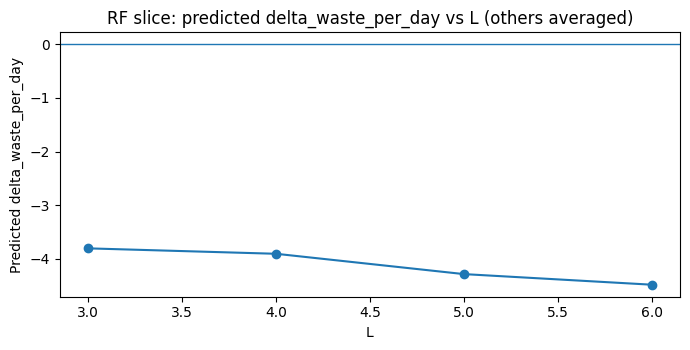

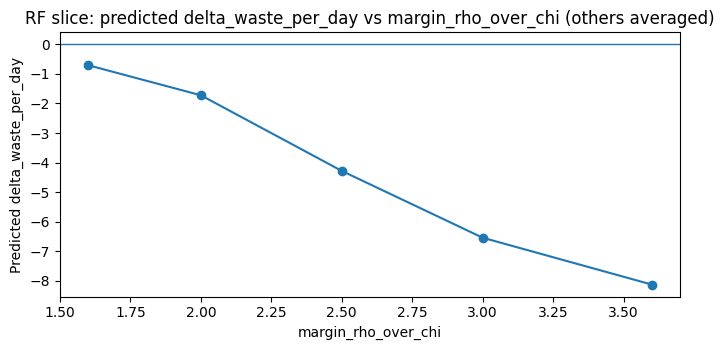

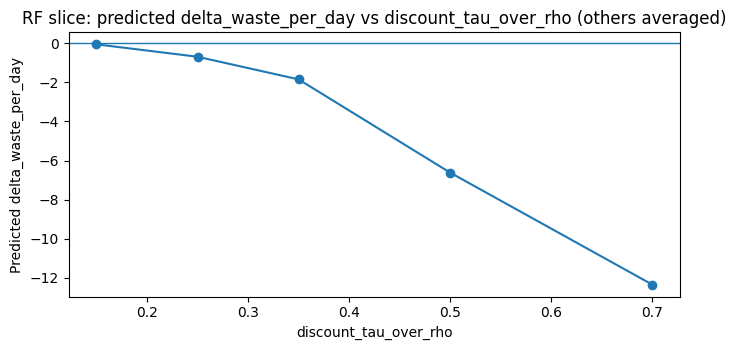

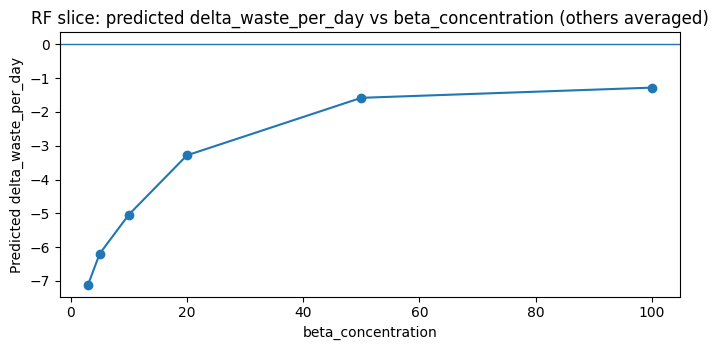

In [ ]:

# Manual "partial dependence style" slices: vary one feature, average predictions
def pdp_1d(model, X_ref: pd.DataFrame, feature: str, grid: list[float]) -> pd.DataFrame:
    rows = []
    for v in grid:
        X_tmp = X_ref.copy()
        X_tmp[feature] = v
        yhat = model.predict(X_tmp)
        rows.append({"feature": feature, "value": v, "pred_mean": float(np.mean(yhat))})
    return pd.DataFrame(rows)

X_ref = df[FEATURES].copy()

for feature in FEATURES:
    grid = sorted(df[feature].unique().tolist())
    pdp = pdp_1d(rf, X_ref, feature, grid)
    fig, ax = plt.subplots(figsize=(7, 3.6))
    ax.plot(pdp["value"], pdp["pred_mean"], marker="o")
    ax.axhline(0, linewidth=1)
    ax.set_title(f"RF slice: predicted {TARGET} vs {feature} (others averaged)")
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Predicted {TARGET}")
    plt.tight_layout()
    plt.show()



## 7) Export dataset

The full grid dataset is exported to the output directory so you can use it elsewhere (R/Stata/Python).

- `waste_grid_results_FINAL.csv`
- `waste_grid_results_FINAL.parquet` (if available)


In [ ]:

df.to_csv(OUT_DIR / "waste_grid_results_FINAL.csv", index=False)
try:
    df.to_parquet(OUT_DIR / "waste_grid_results_FINAL.parquet", index=False)
except Exception:
    pass

OUT_DIR


PosixPath('tgtg_waste_grid_outputs')